In [17]:
import cv2
import os
from scipy.ndimage import gaussian_filter
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from samples.fluo_n2dh import fluo_n2dh

%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = r"G:\DataForDL\logs\mrcnn\fluo_n2dh20200331T2059_fasterRCNN"

In [2]:
# Dataset directory
DATASET_DIR = r"G:\DataForDL\data\cell_tracking_cha\export\fluo_n2dh"

# Inference Configuration
config = fluo_n2dh.CustoInferenceConfig()
# config.display()

In [3]:
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

In [4]:
# Load validation dataset
dataset = fluo_n2dh.CustoDataset()
dataset.load_custo(DATASET_DIR, "valid")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 56
Classes: ['BG', 'custo']


In [5]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

# Path to a specific weights file
weights_path = os.path.join(LOGS_DIR, "mask_rcnn_custo_0020.h5")

# Or, load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  G:\DataForDL\logs\mrcnn\fluo_n2dh20200331T2059_fasterRCNN\mask_rcnn_custo_0020.h5








In [24]:
image_id = 0
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect([image], verbose=1)

# Display results
r = results[0]

image ID: custo.t002.tif (0) t002.tif
Original image shape:  [1024 1024    3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  183.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   79.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


In [76]:
masks = utils.bbox2mask(r['rois'], image, filled=False)

In [95]:
shit = [gaussian_filter(masks[:,:,idx],2)>0.5 for idx in range(masks.shape[-1])]
shit = np.stack(masks, axis=-1)
shit.shape

(512, 23, 512)

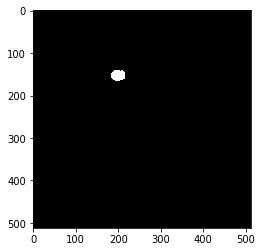

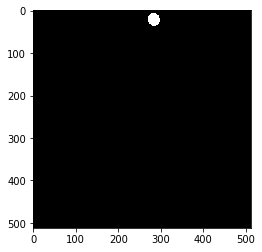

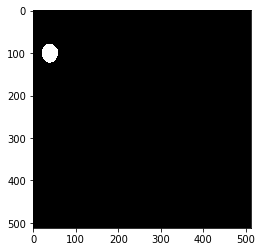

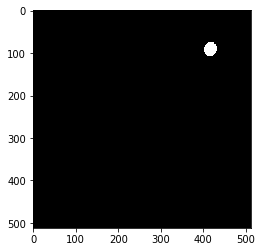

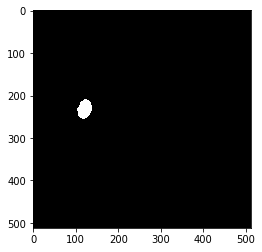

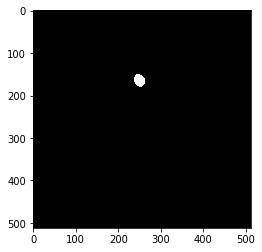

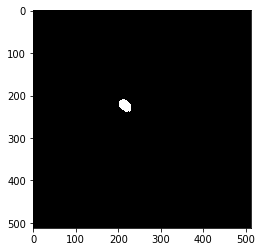

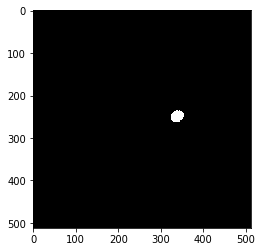

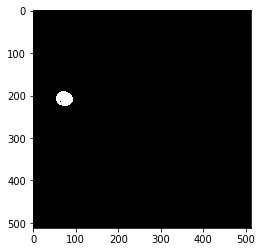

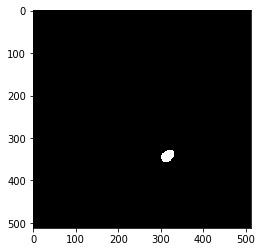

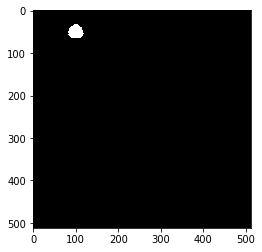

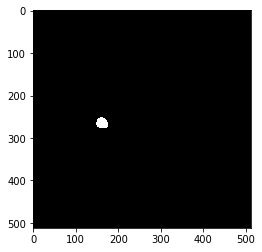

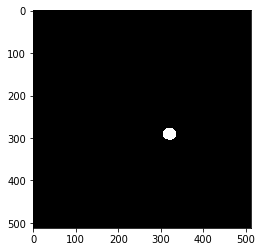

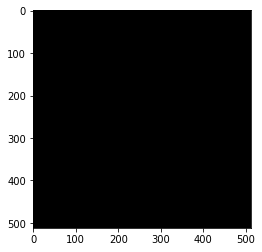

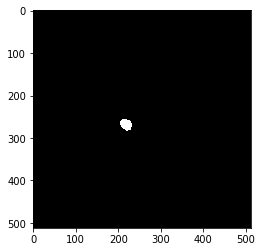

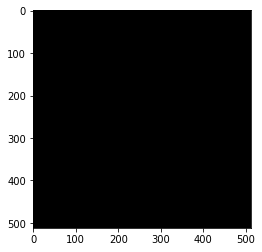

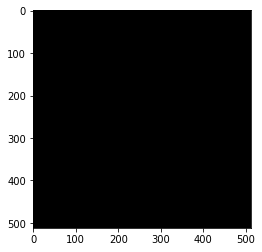

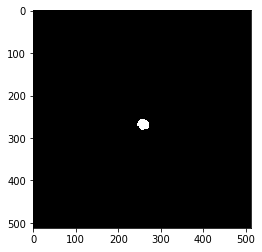

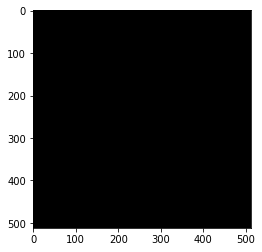

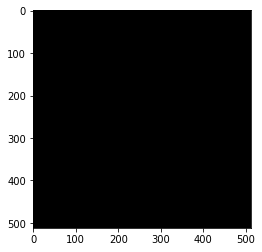

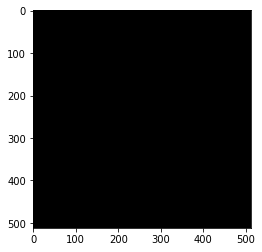

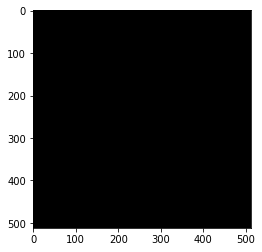

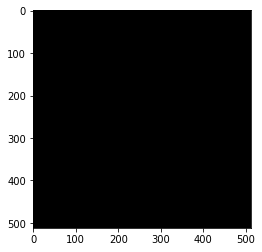

In [86]:
for idx in range(masks.shape[-1]):
    plt.imshow(masks[:,:,idx], cmap='gray')
    plt.show()

In [19]:
def compute_mask_iou(gt_mask, pred_mask):
    intersect = np.sum(gt_mask*pred_mask)
    union = gt_mask.sum()+pred_mask.sum()-intersect
    return intersect*1./union

In [96]:
# detection result of Faster RCNN on fluo_n2dh
iou, AP_5, AP_75 = [], [], []
for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                           dataset.image_reference(image_id)))
    print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

    # Run object detection
    results = model.detect([image], verbose=1)

    # Display results
    r = results[0]
    masks = utils.bbox2mask(r['rois'], image)
    for idx in range(masks.shape[-1]):
        masks[:,:,idx] = gaussian_filter(masks[:,:,idx], 2)>0.5

    # compute iou
    union_mask_label = np.where(gt_mask.sum(axis=-1)==0, 0, 1)
    union_mask_pred = np.where(masks.sum(axis=-1)==0, 0, 1)
    iou.append(compute_mask_iou(union_mask_label, union_mask_pred))
    
    # compute ap
    ap, _, _, _ = utils.compute_ap(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], masks,
            iou_threshold=0.5)
    AP_5.append(ap)
    ap, _, _, _ = utils.compute_ap(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], masks,
            iou_threshold=0.75)    
    AP_75.append(ap)
    del results, r, gt_mask, gt_bbox, image, masks
    print(iou[-1], AP_5[-1], AP_75[-1])

image ID: custo.t002.tif (0) t002.tif
Original image shape:  [1024 1024    3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  183.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   79.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
0.6445070422535212 0.6712121228377025 0.6712121228377025
image ID: custo.t003.tif (1) t003.tif
Original image shape:  [1024 1024    3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  202.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   98.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05

0.7552910828398898 0.7591036558151245 0.7591036558151245
image ID: custo.t056.tif (16) t056.tif
Original image shape:  [1024 1024    3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  171.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   67.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
0.7551344671335256 0.754385979552018 0.754385979552018
image ID: custo.t057.tif (17) t057.tif
Original image shape:  [1024 1024    3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  180.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   76.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  s

0.7257110234585842 0.6788846946748576 0.6788846946748576
image ID: custo.t115.tif (32) t115.tif
Original image shape:  [1024 1024    3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:   93.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  -10.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
0.7043024248205231 0.6591540240880215 0.6591540240880215
image ID: custo.t119.tif (33) t119.tif
Original image shape:  [1024 1024    3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:   78.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  -25.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                 

0.5515277269213557 0.49279950177773085 0.49279950177773085
image ID: custo.t154.tif (48) t154.tif
Original image shape:  [1024 1024    3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  100.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   -3.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
0.5701758014477766 0.47114884606578894 0.47114884606578894
image ID: custo.t157.tif (49) t157.tif
Original image shape:  [1024 1024    3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:   76.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  -27.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors             

In [21]:
# train faster RCNN with all_ims+all_ins+aug, use grabcut mask, restore from epoch 20
# gaussian filter grabcut mask
np.mean(iou), np.mean(AP_5), np.mean(AP_75)

(0.0, 0.0, 0.0)

In [15]:
# train faster RCNN with all_ims+all_ins+aug, use grabcut mask, restore from epoch 20
np.mean(iou), np.mean(AP_5), np.mean(AP_75)

(0.6683522877765512, 0.6428932228496789, 0.6412299452899363)

image ID: custo.t002.tif (0) t002.tif
Original image shape:  [1024 1024    3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  183.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   79.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
image ID: custo.t003.tif (1) t003.tif
Original image shape:  [1024 1024    3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  202.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   98.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
image ID: custo.t005.tif (2) t005.tif
Origin

image ID: custo.t059.tif (18) t059.tif
Original image shape:  [1024 1024    3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  167.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   63.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
image ID: custo.t061.tif (19) t061.tif
Original image shape:  [1024 1024    3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  183.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   79.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
image ID: custo.t066.tif (20) t066.tif
Ori

KeyboardInterrupt: 

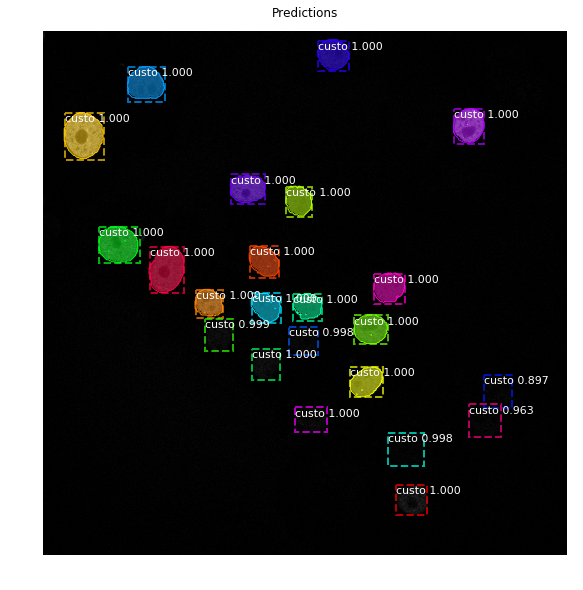

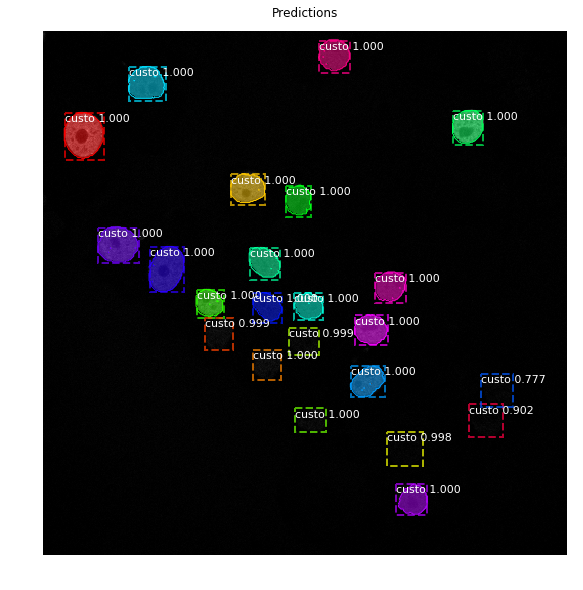

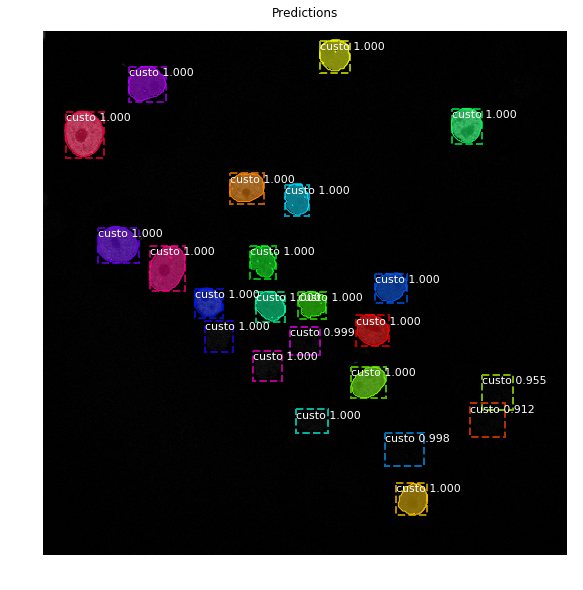

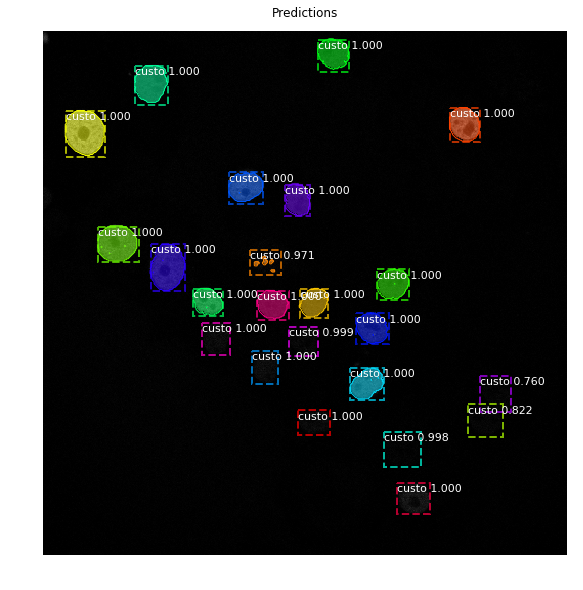

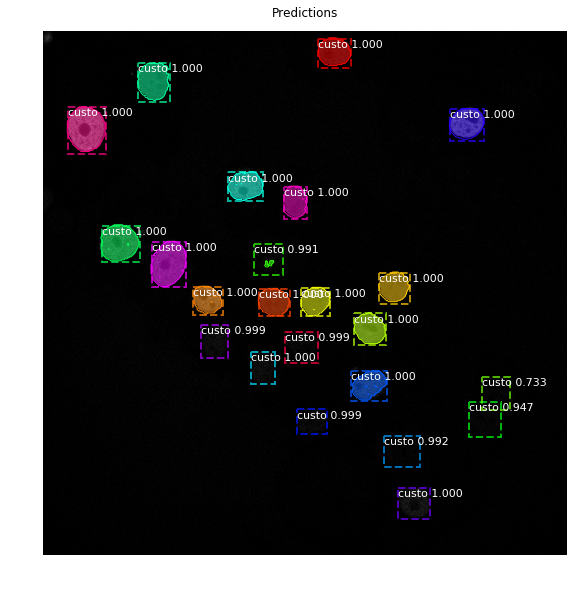

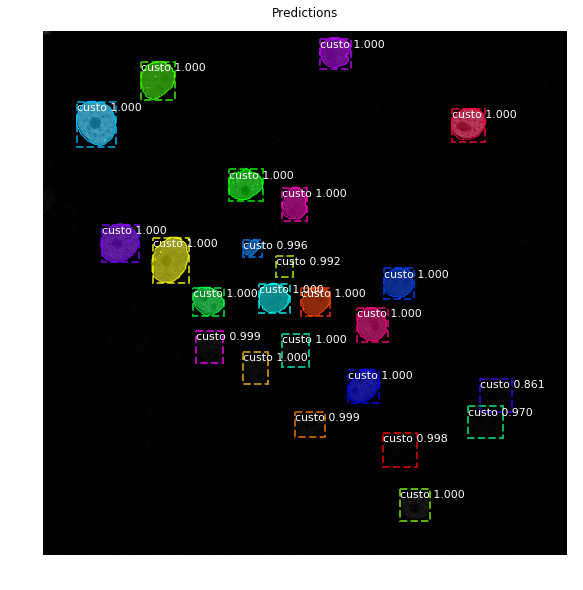

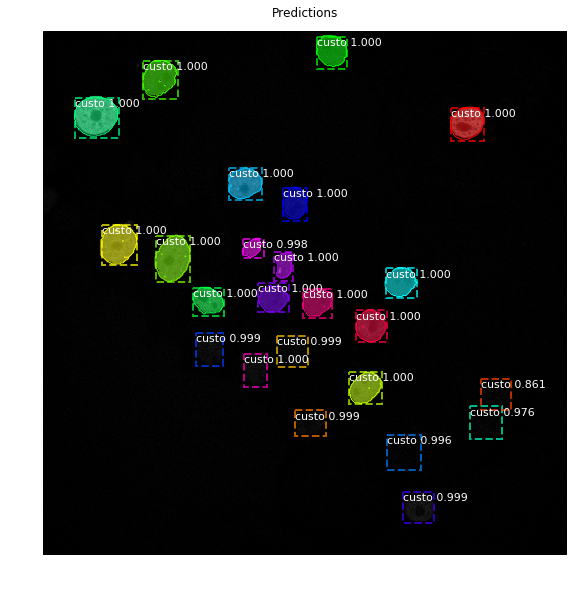

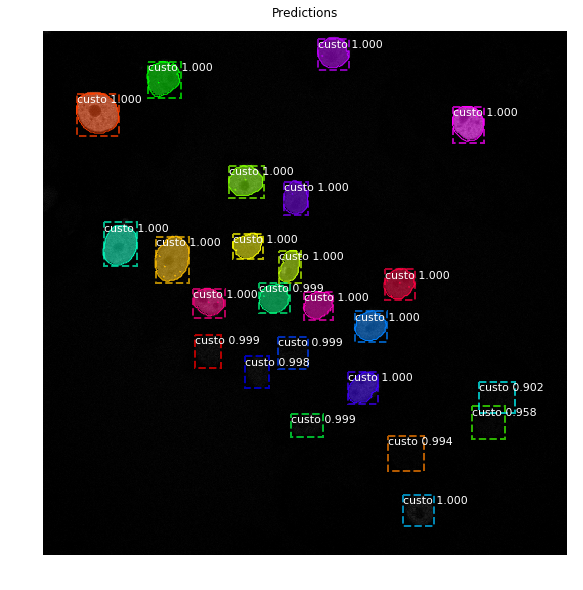

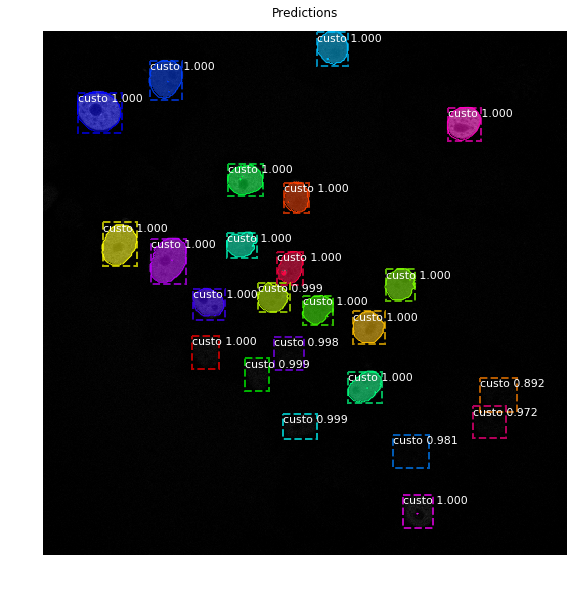

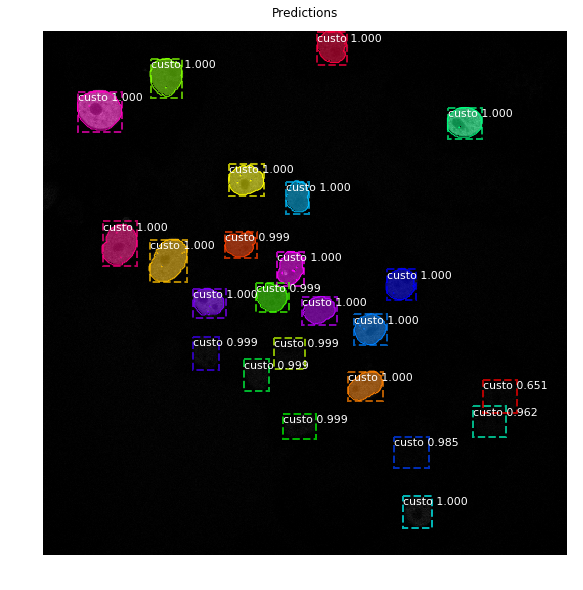

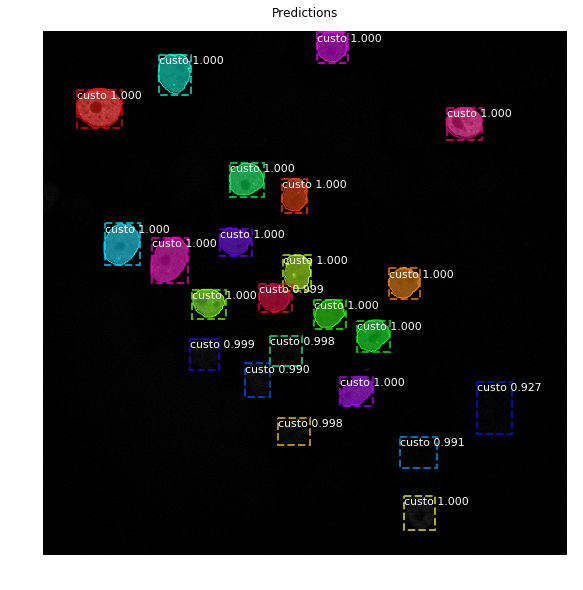

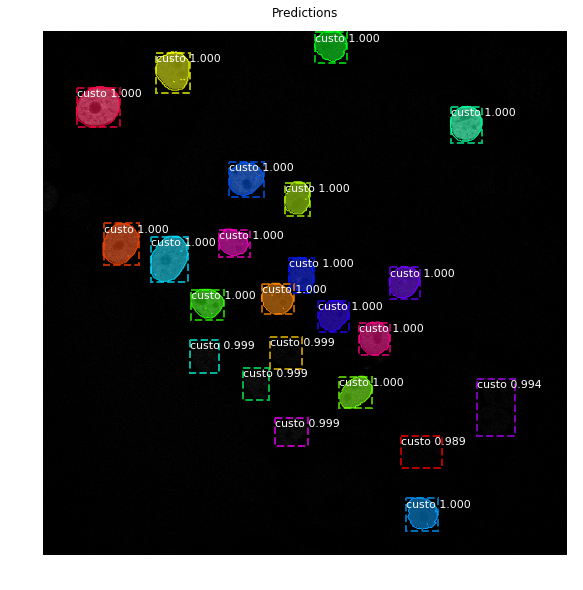

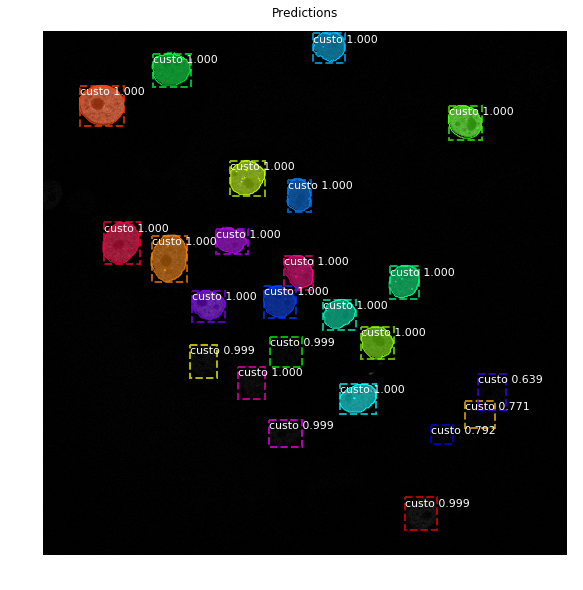

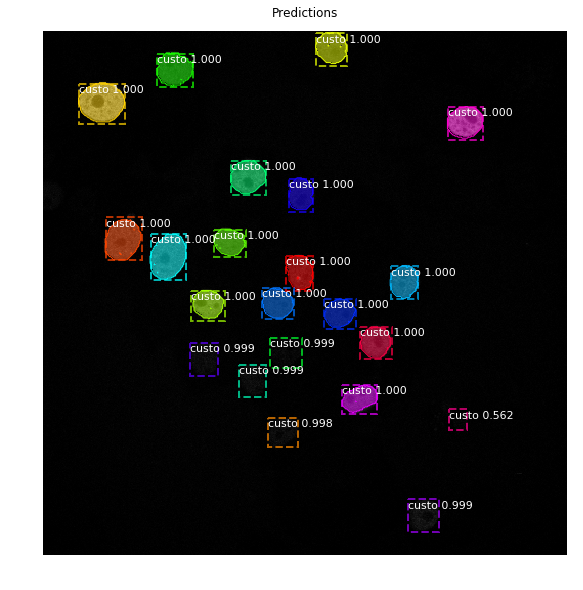

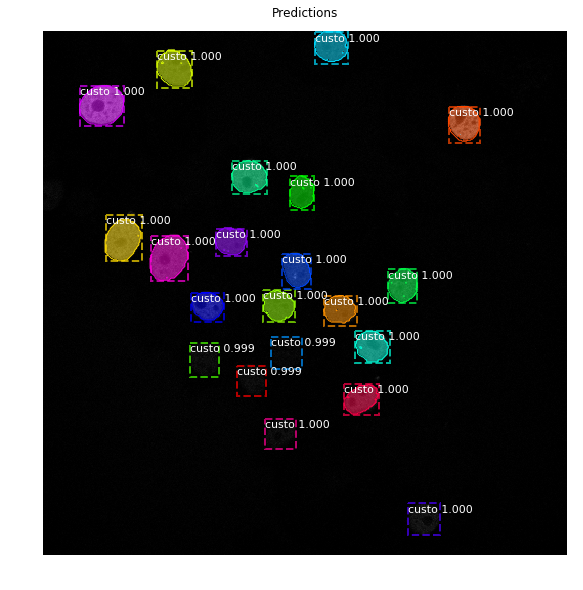

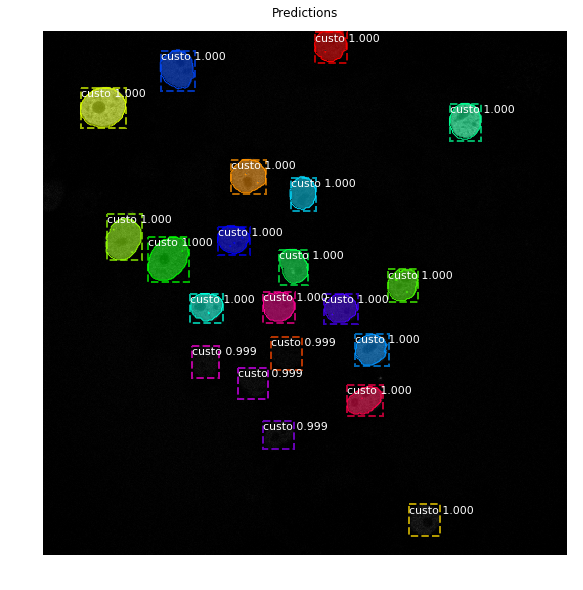

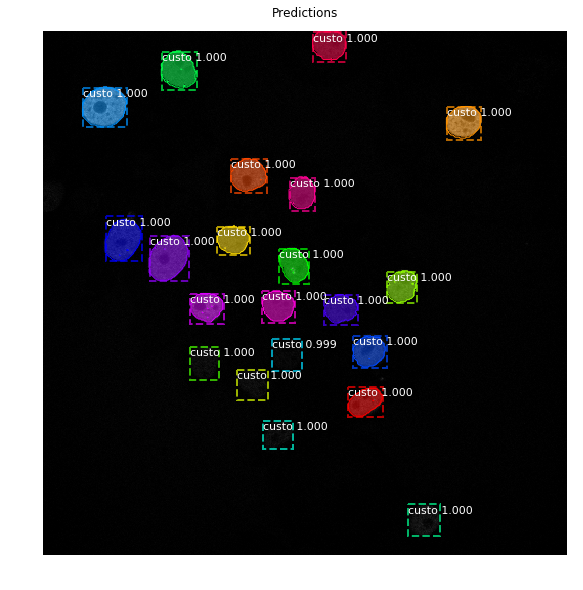

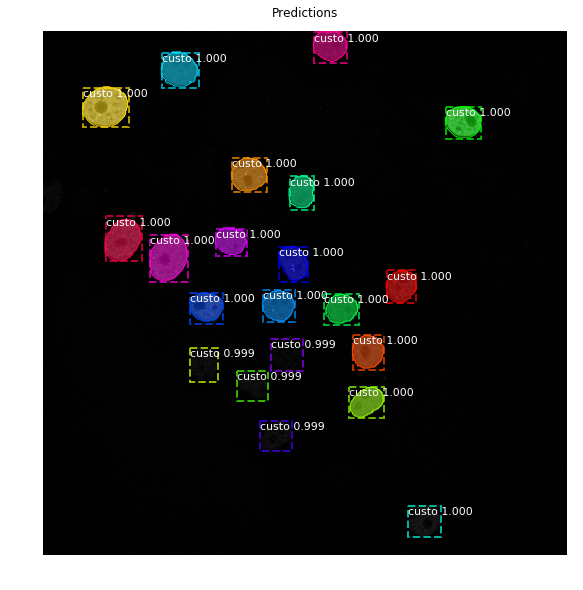

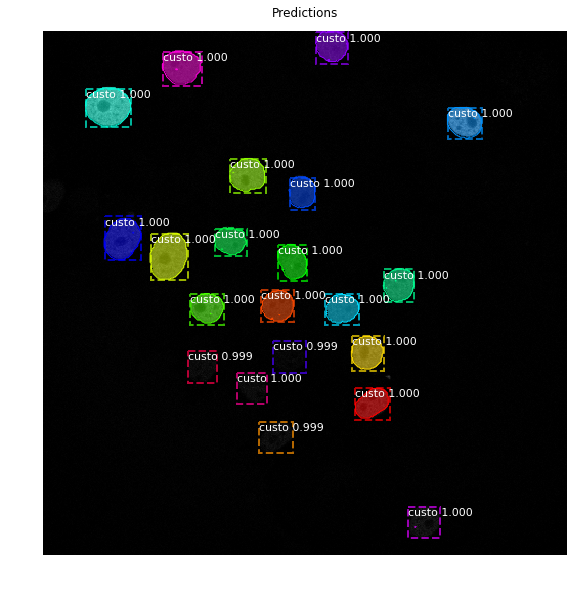

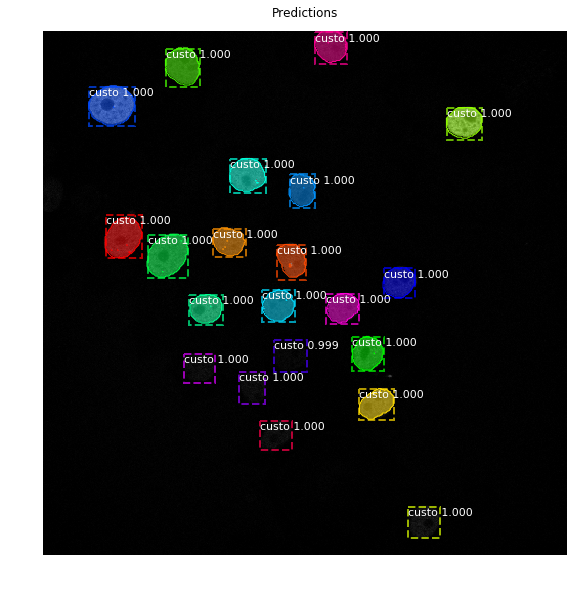

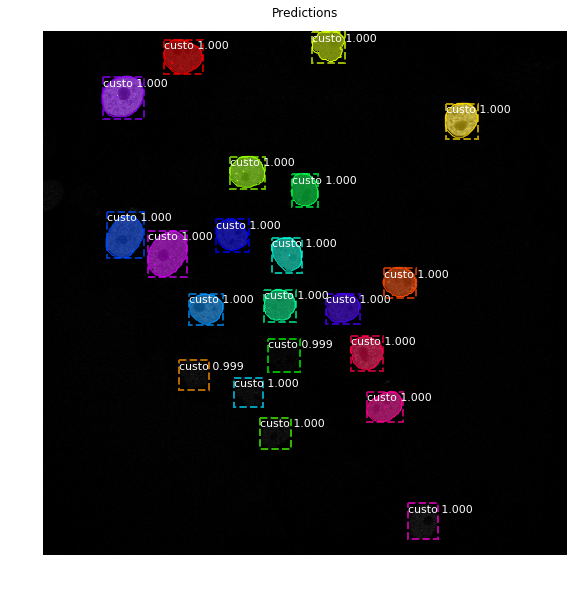

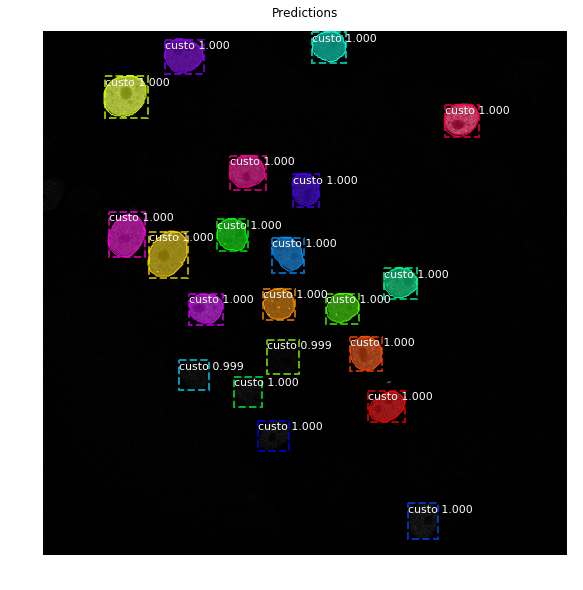

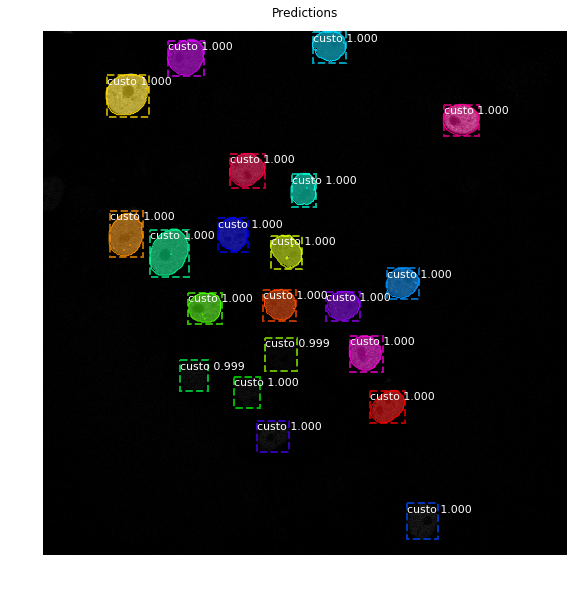

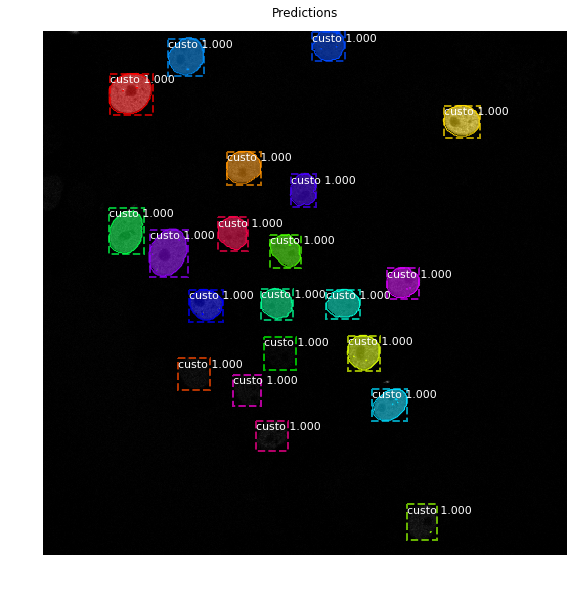

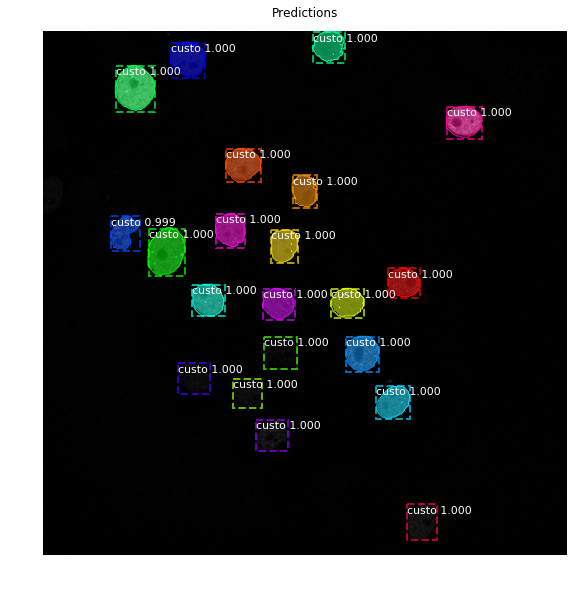

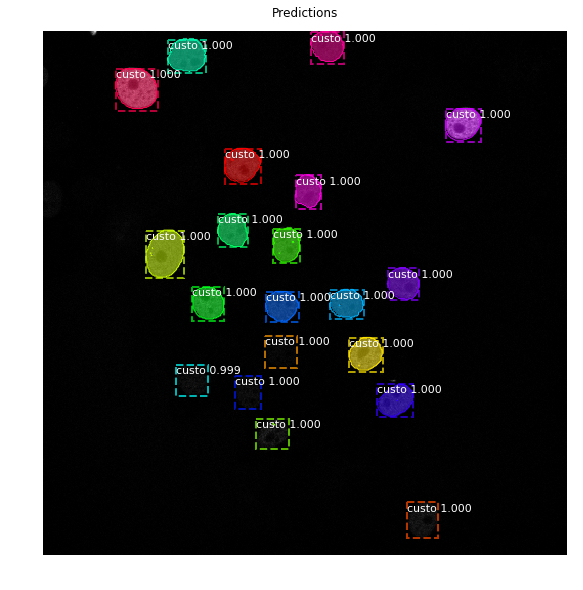

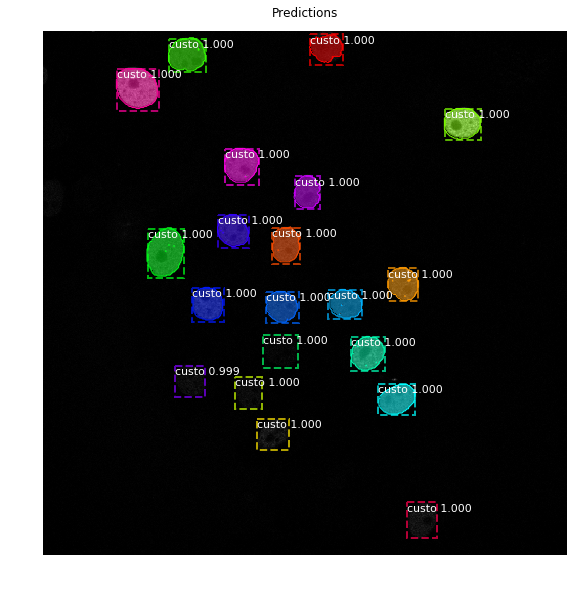

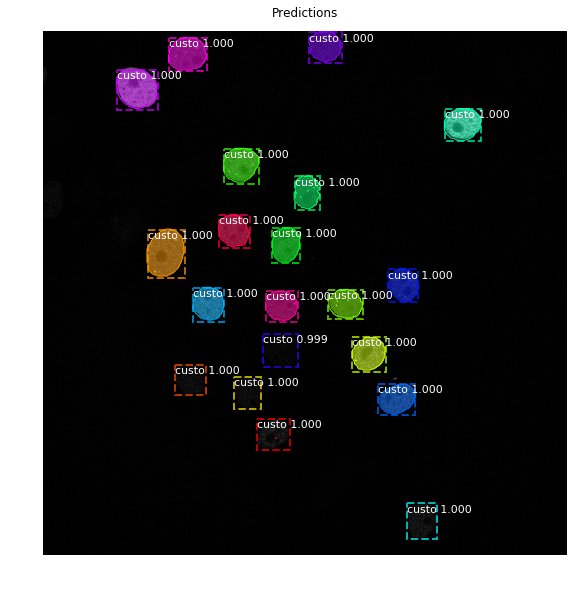

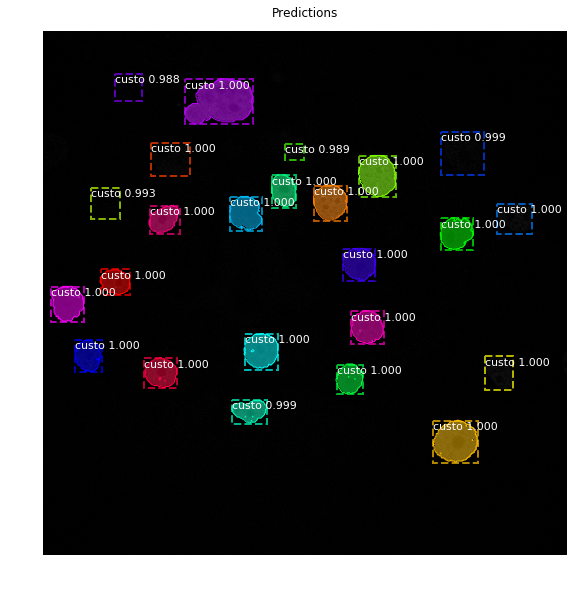

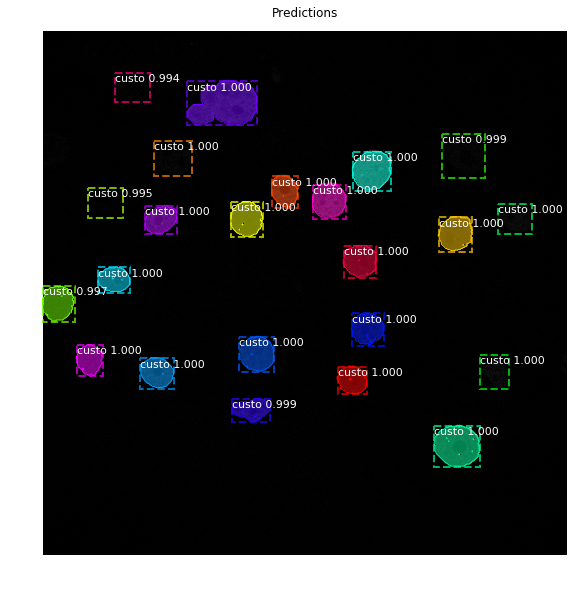

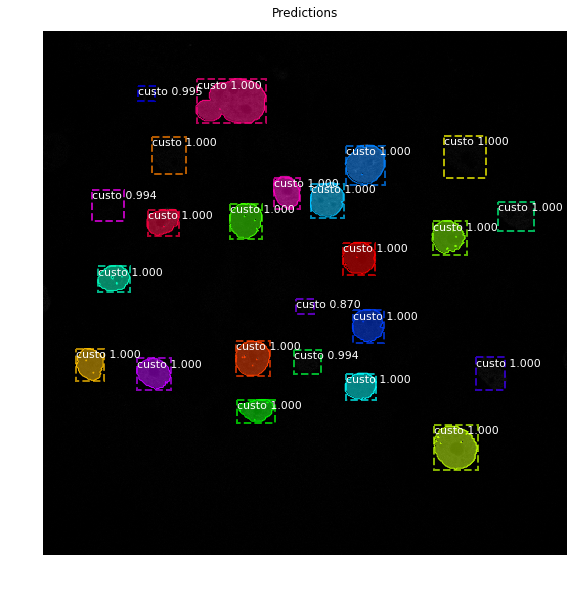

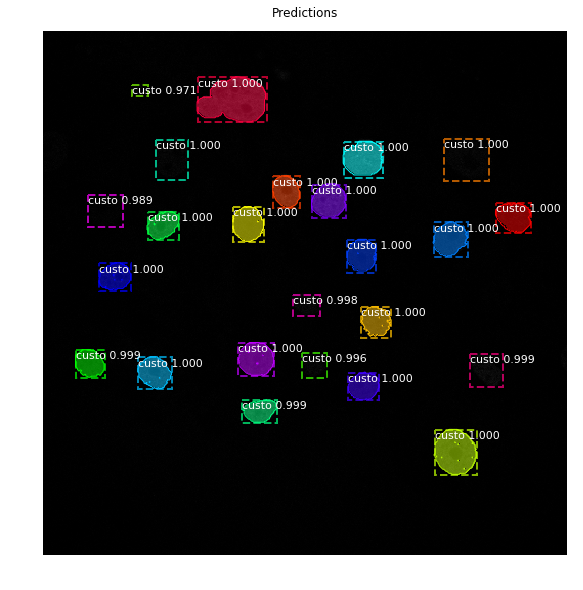

In [10]:
# show seg result of Faster RCNN with Grabcut on fluo_n2dh
matplotlib.use('Agg')
submit_dir = r'G:\DataForDL\results\fluo_n2dh\submit_20200401T0919_fasterRCNN_grabcut'
if not os.path.exists(submit_dir):
    os.makedirs(submit_dir, exist_ok=True)
for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                           dataset.image_reference(image_id)))
    print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

    # Run object detection
    results = model.detect([image], verbose=1)

    # Display results
    r = results[0]
    masks = utils.bbox2mask(r['rois'], image)
    visualize.display_instances(image, r['rois'], masks, r['class_ids'], 
                            dataset.class_names, r['scores'], figsize=(10,10),
                            show_bbox=True, show_mask=True,
                            title="Predictions")
    plt.savefig("{}/{}.png".format(submit_dir, info['id'][:4]))